In [3]:
#Contains all imports and functions

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework import ops
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import cv2
import os
import tensorflowjs as tfjs

%matplotlib inline

    
def convert_to_one_hot(Y, C):
    Y = Y.astype(int)
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
    
def show_last_nine():   #disaply last 9 randomised images in most recently loaded set
    print('Display last nine test images')
    c = 0;
    for i in range(y_test.shape[0]-9, y_test.shape[0]):
        #3 digit number represents row, col, pos
        plt.subplot(331 + c)
        plt.imshow(x_test[i]/255)
        print(vals[int(y_test[i])], end=" ")
        c+=1
    plt.show()
    
def load_data(start, end, rand_ord):
    print('Start ' + str(start) + ' End ' + str(end) + '/' + str(samples) + ' and their mirrors')
    this_size = end - start
    xdata = np.zeros((this_size, w, h, 3))      #Initialise arrays
    ydata = np.zeros(this_size)
    for i in range(start, end):  #Groups of size mini_batch_size
        im_details = image_details[rand_ord[i]]    #folder name, value position(1, 2, 3 == a, b, c etc), image number
        
        #Read images, convert to array and populate temp array
        img = load_img(im_details[0] + '/' + str(vals[im_details[1]]) + str(im_details[2]) + '.png', target_size=(w, h))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        xdata[i-start] = x
        ydata[i-start] = im_details[1] 
    xdata = np.concatenate((xdata, np.flip(xdata, 2)), axis=0)   #Add mirrored images to end of array
    ydata = np.concatenate((ydata, ydata))                       #Copy ydata twice
    return xdata, ydata
    
    #improve speed by saving entire image set as hdf5 then loading in parts
def load_incrementally_and_train(model_name):
    print('Randomised order ')
    print(random_order)  
    print('Number of samples ' + str(samples))
    print('Number of train samples ' + str(train_size))
    print('Number of test samples ' + str(test_size))
    
    print('===Train===')
    for m in range(groups):    #Load training images in groups and train model
        x_data, y_data = load_data(m*mini_batch_size, (m+1)*mini_batch_size, random_order)
        #model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T)
        model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T, validation_split=0.1)
    
    #Load last set of training samples. Group of size mini_batch_size or less
    x_data, y_data = load_data(groups*mini_batch_size, train_size, random_order)
    model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T, validation_split=0.1)
    print('Model has been trained')
        
    #Load test samples
    print('===Test===')
    x_data, y_data = load_data(train_size, samples, random_order)
    model.evaluate(x_data,  convert_to_one_hot(y_data, num_of_classes).T, verbose=2)
    print(' ')
    return x_data, y_data, model  #Returns trained model and test dataset in case more testing needed

def order_folders():
    camcl = []
    for i in range(0, len(im_folder)):
        for j in range(0, im_folder[i][1]*num_of_classes):
            camcl.append([im_folder[i][0], np.floor(j/im_folder[i][1]).astype(int), j%im_folder[i][1]])
    return camcl

In [4]:
w = 200
h = 200
vals = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','SPACE']

num_of_classes = len(vals)

im_folder = []
im_folder.append(['images', 400])
#im_folder.append(['images/images2', 50])
#im_folder.append(['images/images3', 50])

image_details = order_folders()   #Stores folder name, letter and number label of each image
test_percentage = 0.1

#Process images
samples = len(image_details)    #Number of images available
test_size = round(samples*test_percentage)   #Number of testing samples
train_size = samples - test_size             #Number of training samples
mini_batch_size = 850                       #data samples loaded at once
groups = int(np.ceil(train_size/mini_batch_size)-1)    #number of iterations before final. Last one is likely not exactly mini_batch_size   

#create list of randomised numbers 0 to data_size
random_order = np.arange(samples)
np.random.shuffle(random_order)

# ==with dropout==
model = Sequential()
model.add(Conv2D(filters=16, strides=(1, 1), kernel_size=5, padding='same', activation='relu', input_shape=(w, h, 3))) 
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, strides=(1, 1), kernel_size=5, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=3, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(num_of_classes, activation='softmax'))
model.compile(lr=0.000001, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 32)      12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)       

Epoch 1/10
Randomised order 
[9727 1090 6757 ... 3468 6575 1920]
Number of samples 10800
Number of train samples 9720
Number of test samples 1080
===Train===
Start 0 End 850/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 60s 39ms/sample - loss: 39.4153 - acc: 0.0353 - val_loss: 3.2972 - val_acc: 0.0353
Start 850 End 1700/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 26s 17ms/sample - loss: 3.2910 - acc: 0.0353 - val_loss: 3.2956 - val_acc: 0.0176
Start 1700 End 2550/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 26s 17ms/sample - loss: 3.2921 - acc: 0.0261 - val_loss: 3.2891 - val_acc: 0.0765
Start 2550 End 3400/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 26s 17ms/sample - loss: 3.2877 - acc: 0.0418 - val_loss:

1530/1530 [==============================] - 3s 2ms/sample - loss: 1.5982 - acc: 0.4824 - val_loss: 1.5723 - val_acc: 0.5118
Start 9350 End 9720/10800 and their mirrors
Train on 666 samples, validate on 74 samples
666/666 [==============================] - 1s 2ms/sample - loss: 1.6251 - acc: 0.4880 - val_loss: 1.6847 - val_acc: 0.4595
Model has been trained
===Test===
Start 9720 End 10800/10800 and their mirrors
2160/1 - 1s - loss: 2.0771 - acc: 0.4606
 
Epoch 4/10
Randomised order 
[9727 1090 6757 ... 3468 6575 1920]
Number of samples 10800
Number of train samples 9720
Number of test samples 1080
===Train===
Start 0 End 850/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 2ms/sample - loss: 1.6067 - acc: 0.4876 - val_loss: 1.6390 - val_acc: 0.5176
Start 850 End 1700/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 3s 2ms/sample - loss: 1.4743 - acc: 

1530/1530 [==============================] - 2s 1ms/sample - loss: 0.5774 - acc: 0.8020 - val_loss: 0.6913 - val_acc: 0.8059
Start 7650 End 8500/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.5681 - acc: 0.8301 - val_loss: 0.6112 - val_acc: 0.8529
Start 8500 End 9350/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 2ms/sample - loss: 0.6331 - acc: 0.8111 - val_loss: 0.7387 - val_acc: 0.7882
Start 9350 End 9720/10800 and their mirrors
Train on 666 samples, validate on 74 samples
666/666 [==============================] - 1s 2ms/sample - loss: 0.7036 - acc: 0.7748 - val_loss: 1.2147 - val_acc: 0.6216
Model has been trained
===Test===
Start 9720 End 10800/10800 and their mirrors
2160/1 - 1s - loss: 1.0033 - acc: 0.6481
 
Epoch 7/10
Randomised order 
[9727 1090 6757 ... 3468 6575 1920]
Number of samples 10800
Number of train samp

1530/1530 [==============================] - 2s 1ms/sample - loss: 0.2889 - acc: 0.8974 - val_loss: 0.3708 - val_acc: 0.8706
Start 5950 End 6800/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.2794 - acc: 0.9118 - val_loss: 0.3924 - val_acc: 0.8824
Start 6800 End 7650/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 2ms/sample - loss: 0.2732 - acc: 0.9105 - val_loss: 0.4450 - val_acc: 0.8588
Start 7650 End 8500/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.2624 - acc: 0.9150 - val_loss: 0.4597 - val_acc: 0.8353
Start 8500 End 9350/10800 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 2ms/sample - loss: 0.3133 - acc: 0.8961 - val_loss: 0.3589 - val_acc: 0.9000
Start 9350 

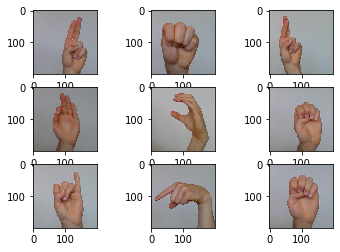

In [5]:
#This file is used when training data is too big. Loads data in batches. Fit function still returns test data as much 
#smaller and gives reference for correct processing. Should be able to be called multiple times to increase epochs.
eps = 10
for i in range(eps):
    print('Epoch ' + str(i+1) + '/' + str(eps))
    x_test, y_test, model = load_incrementally_and_train(model)
show_last_nine()

              precision    recall  f1-score   support

           A       0.99      0.95      0.97        94
           B       0.91      1.00      0.96        86
           C       0.97      0.97      0.97        72
           D       0.95      0.99      0.97        74
           E       0.84      0.95      0.89        82
           F       1.00      0.95      0.97        96
           G       0.84      1.00      0.91        68
           H       1.00      0.99      1.00       106
           I       0.98      1.00      0.99        80
           J       0.91      0.99      0.95        72
           K       0.88      0.93      0.91        92
           L       0.99      0.97      0.98        88
           M       0.84      0.86      0.85        66
           N       0.92      0.91      0.91        98
           O       0.96      0.92      0.94        52
           P       0.98      0.90      0.94        90
           Q       1.00      0.95      0.97        78
           R       0.89    

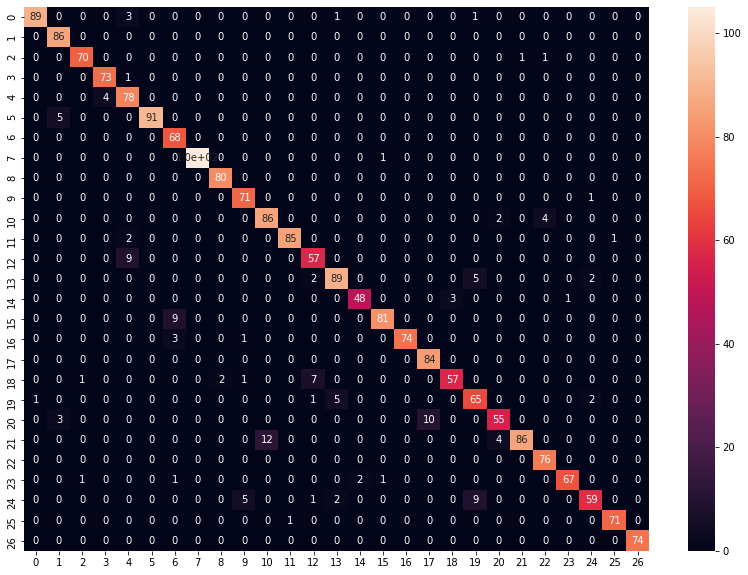

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# get the predictions for the test data
predicted_classes = model.predict_classes(x_test)

cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (14,10))
sns.heatmap(cm, annot=True)

from sklearn.metrics import classification_report

num_classes = 27
target_names = ["{}".format(vals[i]) for i in range(num_of_classes)]

print(classification_report(y_test, predicted_classes, target_names = target_names))

In [29]:
#=====Save model for use in tfjs
tfjs.converters.save_keras_model(model, 'tf_models/New_CNN_Model')